# install & import

In [1]:
# !pip install diffusers[training]
!pip install torchvision

In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! You have GPU access.")
else:
    print("CUDA is not available. You do not have GPU access.")

CUDA is not available. You do not have GPU access.


In [8]:
from dataclasses import dataclass
from datasets import load_dataset
import matplotlib.pyplot as plt
from dataclasses import dataclass
import glob
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import os
import random

# Load dataset

In [5]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-kaist-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "richidubey/diff-rgb-model-fin"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [ ]:
#full set
# config.dataset_name = "richidubey/KAIST-Multispectral-Pedestrian-Detection-Dataset"
# dataset = load_dataset(config.dataset_name, split="train")

In [7]:
#fMiniset
config.dataset_name = "richidubey/Mini-KAIST-Multispectral-Pedestrian-Detection-Dataset"
dataset = load_dataset(config.dataset_name, split="train")

C:\Users\sywis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sywis\.cache\huggingface\hub\datasets--richidubey--Mini-KAIST-Multispectral-Pedestrian-Detection-Dataset. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warn

# New RGB Image generators

# New RGB to Thermal Generator

In [24]:
OUTPUT_CHANNELS = 3

generator_rgb2thermal = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

load model check points

In [16]:
checkpoint_path = "./rgb2thermal_checkpoints/train"

In [38]:
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_rgb2thermal,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

# Assuming you have already defined your generator and discriminator models
checkpoint = tf.train.Checkpoint(generator_g=generator_g)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
print("Generator G restored from checkpoint")

Latest checkpoint restored!!
Generator G restored from checkpoint


test generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I01174.jpg


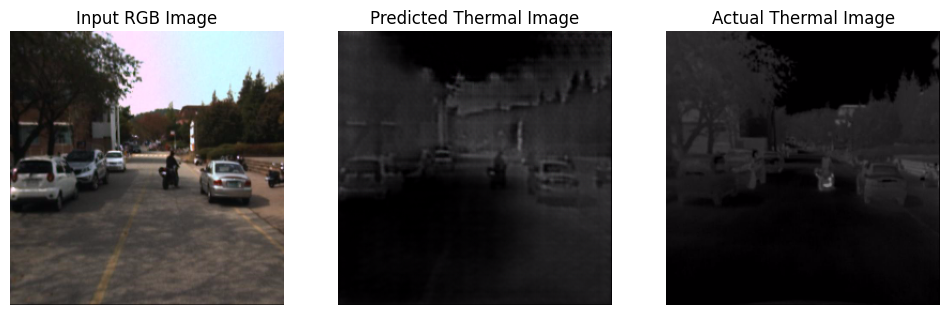

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I00451.jpg


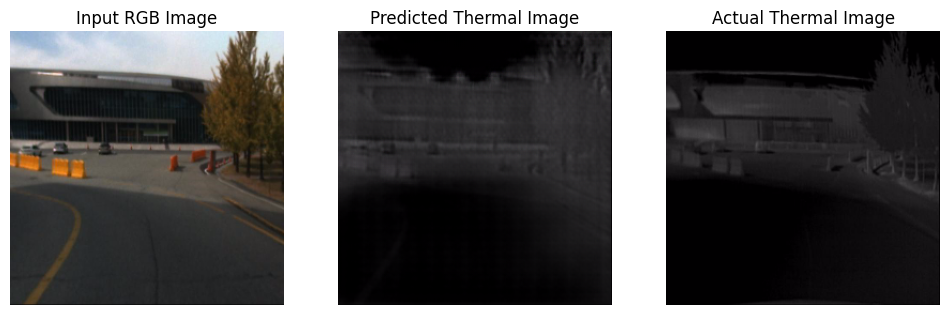

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I01761.jpg


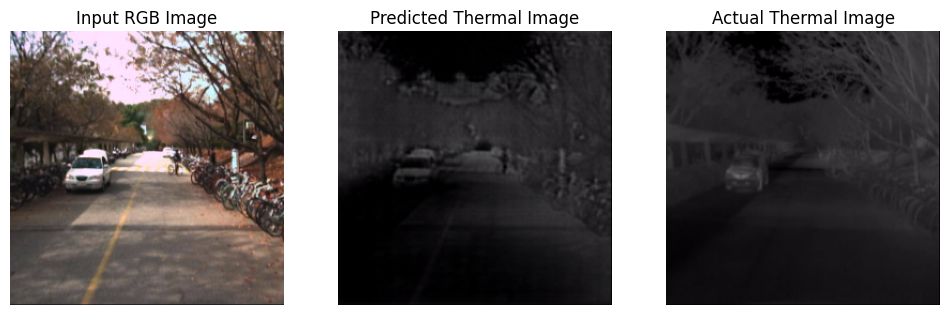

In [39]:
def recon_image(path):
    # Read the image file
    image_raw = tf.io.read_file(path)

    # Decode the image
    image_tensor = tf.io.decode_image(image_raw, channels=3)

    # Ensure the tensor is of type float32 and scale the values to [0, 1]
    image_tensor = tf.cast(image_tensor, tf.float32) / 255.0

    # Resize the image to match the expected input shape of your model
    # Replace 256 and 256 with the expected height and width of your model's input
    image_tensor = tf.image.resize(image_tensor, [256, 256])

    # Add a batch dimension
    image_tensor = tf.expand_dims(image_tensor, 0)
    
    return image_tensor

# Set the path to your directory
test_rgb  = r"C:\Users\sywis\Downloads\kaist-cvpr15\kaist-cvpr15\images\set00\V000\visible"
test_lwir = r"C:\Users\sywis\Downloads\kaist-cvpr15\kaist-cvpr15\images\set00\V000\lwir"

full_list = os.listdir(test_rgb)
image_files = random.sample(full_list, 3)
for image_file in image_files:
    
    rgb_image_path = os.path.join(test_rgb, image_file)
    
    thermal_image_file = image_file.replace('visible.png', 'lwir.png')
    thermal_image_path = os.path.join(test_lwir, thermal_image_file)
    print(thermal_image_file)
    
    plt.figure(figsize=(12, 12))
    
    test_input = recon_image(rgb_image_path)
    test_output = recon_image(thermal_image_path)
    
    # Now you can pass this tensor to your model
    prediction = generator_rgb2thermal(test_input)

    display_list = [test_input, prediction, test_output]
    title = ['Input RGB Image', 'Predicted Thermal Image', 'Actual Thermal Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i][0])
        plt.axis('off')
    plt.show()

# New Images Labels